# Import packages

In [2]:
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
import scipy
from scipy import interpolate
from scipy import fftpack
from scipy import signal
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer
from ephyviewer import InMemoryAnalogSignalSource
import ephyviewer


### Load data

### Load recordings
date_time = os.path.basename(os.getcwd())
Letter = "J:"
#Letter = 'H:\Annie\Enregistrements 9-20 juin 23'

nb_E = 15    #Ajuster selon nb d'Electrodes!
nb_mice = 1

stim = np.load(f"{Letter}/{date_time}/Record Node 101/experiment1/recording1/events/Acquisition_Board-100.Rhythm Data/TTL/sample_numbers.npy")
channel_states = np.load(f"{Letter}/{date_time}/Record Node 101/experiment1/recording1/events/Acquisition_Board-100.Rhythm Data/TTL/states.npy")
cont = np.load(f"{Letter}/{date_time}/Record Node 101/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/sample_numbers.npy")


folder = Path(f'{Letter}/{date_time}/Record Node 101/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data').absolute()
list_raw = []
for file_path in folder.glob('**/*.dat'):
    subfolder = file_path.parents[1].stem
    if subfolder == 'continuous':
        recording = file_path.parents[2].stem.replace('recording','')
        file = file_path.stem
        print(recording)
        globals()[f"DataRec_{recording}"] = np.fromfile(file_path, dtype="int16")
        globals()[f"DataRaw_{recording}"] = globals()[f"DataRec_{recording}"].reshape(-1,32*nb_mice)
        list_raw.append(f"DataRaw_{recording}")


## Distribute channels.
#WARNING: this has to be adjusted for every mouse. In the future, add a cell at the beginning to enter these parameters

list_rawchan = []

for ele2, file in enumerate(list_raw, start=1):
    # Distribute
    EMG = globals()[f"DataRaw_{ele2}"][:,6]
    E1a = globals()[f"DataRaw_{ele2}"][:,0]
    E1b = globals()[f"DataRaw_{ele2}"][:,1]
    E2a = globals()[f"DataRaw_{ele2}"][:,2]
    E2b = globals()[f"DataRaw_{ele2}"][:,3]
    E3a = globals()[f"DataRaw_{ele2}"][:,4]
    E3b = globals()[f"DataRaw_{ele2}"][:,5]
    E4a = globals()[f"DataRaw_{ele2}"][:,8]
    E4b = globals()[f"DataRaw_{ele2}"][:,9]
    E5a = globals()[f"DataRaw_{ele2}"][:,10]
    E5b = globals()[f"DataRaw_{ele2}"][:,11]
    E6a = globals()[f"DataRaw_{ele2}"][:,12]
    E6b = globals()[f"DataRaw_{ele2}"][:,13]
    E7a = globals()[f"DataRaw_{ele2}"][:,14]
    E7b = globals()[f"DataRaw_{ele2}"][:,15]
    E8a = globals()[f"DataRaw_{ele2}"][:,16]
    E8b = globals()[f"DataRaw_{ele2}"][:,17]
    E9a = globals()[f"DataRaw_{ele2}"][:,18]
    E9b = globals()[f"DataRaw_{ele2}"][:,19]
    E10a = globals()[f"DataRaw_{ele2}"][:,20]
    E10b = globals()[f"DataRaw_{ele2}"][:,21]
    E11a = globals()[f"DataRaw_{ele2}"][:,22]
    E11b = globals()[f"DataRaw_{ele2}"][:,23]
    E12a = globals()[f"DataRaw_{ele2}"][:,24]
    E12b = globals()[f"DataRaw_{ele2}"][:,25]
    E13a = globals()[f"DataRaw_{ele2}"][:,26]
    E13b = globals()[f"DataRaw_{ele2}"][:,27]
    E14a = globals()[f"DataRaw_{ele2}"][:,28]
    E14b = globals()[f"DataRaw_{ele2}"][:,29]
    E15a = globals()[f"DataRaw_{ele2}"][:,30]
    E15b = globals()[f"DataRaw_{ele2}"][:,31]

    # Stack back
    globals()[f"Good_channels_{ele2}"] = np.stack((EMG, E1a, E1b, E2a, E2b, E3a, E3b, E4a, E4b, E5a, E5b, E6a, E6b, E7a, E7b, E8a, E8b, E9a, E9b, E10a, E10b, E11a, E11b, E12a, E12b, E13a, E13b, E14a, E14b, E15a, E15b), axis = 1)#.reshape(-1, 4)
    nmberchann = globals()[f"Good_channels_{ele2}"].shape
    datalen = globals()[f"Good_channels_{ele2}"].size / nmberchann[1]
    print(datalen)
    coords = {
        'brain_areas' : np.array(['EMG,', 'E1a,', 'E1b,', 'E2a,', 'E2b,', 'E3a,', 'E3b,', 'E4a,', 'E4b,', 'E5a,', 'E5b,', 'E6a,', 'E6b,', 'E7a,', 'E7b,', 'E8a,', 'E8b,', 'E9a,', 'E9b,', 'E10a,', 'E10b,', 'E11a,', 'E11b,', 'E12a,', 'E12b,', 'E13a,', 'E13b', 'E14a,', 'E14b', 'E15a,', 'E15b']),
        'duration_rec' : np.arange(0, datalen/2000, 1/2000)
    }
    # Put in xarray
    globals()[f"xrGoodChannels_{ele2}"] = xr.DataArray(coords=coords, dims=['duration_rec', 'brain_areas'])
    globals()[f"xrGoodChannels_{ele2}"].loc[:,:]  = globals()[f"Good_channels_{ele2}"]
    Good_channels = globals()[f"xrGoodChannels_{ele2}"]
    # Save data
    np.save(f'RawDataChannelExtracted_{ele2}.npy', Good_channels)
    list_rawchan.append(Good_channels)
    # Empty array to free memory 
    globals()[f"DataRaw_{ele2}"] = None


###  Downsample all signals to 1 kz.

#list_rawchan = [xrGoodChannels_1, xrGoodChannels_2]
list_rawchan_filt = []
for ele, file in enumerate(list_rawchan):
    #ele2 = ele + 1
    print(ele2)
    sampling_rate = 2000 # Hz
    new_sampling_rate = 1000 # Hz
    nmberchann = file.shape
    datalen = file.size/ nmberchann[1]
    Nmber_points = int(datalen * new_sampling_rate / sampling_rate)
    print(datalen, Nmber_points)
    globals()[f"DS_GoodChannels_{ele2}"] = signal.resample(file, Nmber_points, axis = 0)
    Good_channels_filtered = globals()[f"DS_GoodChannels_{ele2}"]
    list_rawchan_filt.append(Good_channels_filtered)
    np.save(f'RawDataChannelExtractedDS_{ele2}.npy', Good_channels_filtered)
    globals()[f"xrGoodChannels_{ele2}"] = None

list_rawchan = None

# if done and no intention to display for assessment
#%reset

#Estimated time: 1 min/GB



# Wake Removing
### Load EMG and downsampled data
# mmap activated to not store everything in memory
All = np.load('RawDataChannelExtractedDS_1.npy', mmap_mode= 'r')
EMG = All[:, 0]

### Create vector to display stims
### TTL 1 ###
# find the indices of the start and end times
start_indices = np.where(channel_states == 1)[0]
end_indices = np.where(channel_states == -1)[0]

# create a new array with the start and end times
stim_times = np.zeros((len(start_indices), 2))
for i in range(len(start_indices)):
    stim_times[i, 0] = stim[start_indices[i]]
    stim_times[i, 1] = stim[end_indices[i]]

#Adjust stim timestamps - start time and sampling frequency
start_time = cont[0]  # in 0.5 milliseconds   #First value of timestamps memmap from 'continuous' folder
print(f'start time = {start_time} in 0.5 ms or {start_time/(2000*60)} in min')
stim_times -= start_time
stim_times = stim_times.astype('float64')
stim_times /= 2.0
stim_times = stim_times.astype('int64')

# Assigning values stim (3) and non stim (0)
display_stim_1 = np.zeros(EMG.size)
for x in stim_times:
    display_stim_1[x[0]:x[1]] = 3



### TTL 2 ###
# find the indices of the start and end times
start_indices = np.where(channel_states == 2)[0]
end_indices = np.where(channel_states == -2)[0]

# create a new array with the start and end times
stim_times = np.zeros((len(start_indices), 2))
for i in range(len(start_indices)):
    stim_times[i, 0] = stim[start_indices[i]]
    stim_times[i, 1] = stim[end_indices[i]]

#Adjust stim timestamps - start time and sampling frequency
start_time = cont[0]  # in 0.5 milliseconds   #First value of timestamps memmap from 'continuous' folder
print(f'start time = {start_time} in 0.5 ms or {start_time/(2000*60)} in min')
stim_times -= start_time
stim_times = stim_times.astype('float64')
stim_times /= 2.0
stim_times = stim_times.astype('int64')

# Assigning values stim (3) and non stim (0)
display_stim_2 = np.zeros(EMG.size)
for x in stim_times:
    display_stim_2[x[0]:x[1]] = 3


### High pass filter
# Filter parameter :
f_lowcut = 200.
f_hicut = 400.
N = 4
fs = 1000
nyq = 0.5 * fs
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

# Filter creation :
b, a = signal.butter(N, Wn, 'band')
filt_EMG = signal.filtfilt(b, a, EMG)


### Continuous Wavelet Transform and projection calculation
# Parameter and computation of CWT
fs = 1000
w = 4.
freq = np.linspace(200, 400, 50)
widths = w*fs / (2*freq*np.pi)
EMGcwt = signal.cwt(EMG, signal.morlet2, widths, w=w)
#filt_EMG au lieu de EMG

# Projection calculation
absEMGcwt = np.absolute(EMGcwt)
proj_EMGcwt = np.sum(absEMGcwt, axis = 0)/50
sdproj_EMGcwt = np.std(proj_EMGcwt)
sd5proj_EMGcwt = sdproj_EMGcwt*5
sd3proj_EMGcwt = sdproj_EMGcwt*3
sd05proj_EMGcwt = sdproj_EMGcwt*0.5
moyproj_EMGcwt = np.mean(proj_EMGcwt)


#For theta activity
# Parameter and computation of CWT
w = 30
freq = np.linspace(5, 9, 9)
widths = w*fs / (2*freq*np.pi)
HPcwt = signal.cwt(All[:, 4], signal.morlet2, widths, w=w)

# Projection calculation
absHPcwt = np.absolute(HPcwt)
proj_HPcwt = np.sum(absHPcwt, axis = 0)/9
sdproj_HPcwt = np.std(proj_HPcwt)
moyproj_HPcwt = np.max(proj_HPcwt)


#For delta activity in Hp
# Parameter and computation of CWT
w = 30
freq = np.linspace(0.5, 4, 15)
widths = w*fs / (2*freq*np.pi)
deltaHPcwt = signal.cwt(All[:, 4], signal.morlet2, widths, w=w)

# Projection calculation
absdeltaHPcwt = np.absolute(deltaHPcwt)
proj_deltaHPcwt = np.sum(absdeltaHPcwt, axis = 0)/15
sdproj_deltaHPcwt = np.std(proj_deltaHPcwt)
moyproj_deltaHPcwt = np.mean(proj_deltaHPcwt)


### Interpretating signal to extract wake (active and quiet) and sleep
rapport = (proj_HPcwt/proj_deltaHPcwt)
moyproj_HPScwt = np.mean(rapport)
sdproj_HPScwt = np.std(rapport)

numpnts = len(rapport)

1
30121216.0
1
30121216.0 15060608
start time = 0 in 0.5 ms or 0.0 in min
start time = 0 in 0.5 ms or 0.0 in min


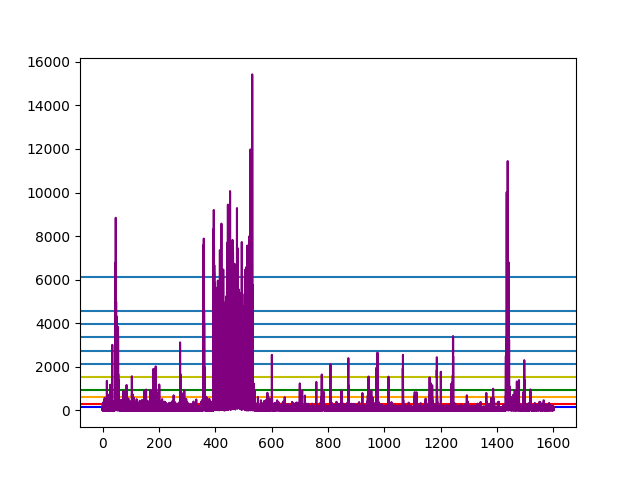

In [3]:
# Defining subset
start = 00000
end = 1600000
times = np.arange(0, EMG.size/fs, 1./fs)

tt = times[start:end]
EMGt = EMG[start:end]
EMGcwtt = EMGcwt[:, start:end]
proj_EMGcwtt = proj_EMGcwt[start:end]

plt.close('all')
plt.axhline(sdproj_EMGcwt, color='r') # horizontal
plt.axhline(sdproj_EMGcwt*2, color='orange') # horizontal
plt.axhline(sd3proj_EMGcwt, color='g') # horizontal
plt.axhline(sd05proj_EMGcwt, color='b') # horizontal
plt.axhline(sd5proj_EMGcwt, color='y') # horizontal
plt.axhline(sdproj_EMGcwt*7) # horizontal
plt.axhline(sdproj_EMGcwt*9) # horizontal
plt.axhline(sdproj_EMGcwt*11) # horizontal
plt.axhline(sdproj_EMGcwt*13) # horizontal
plt.axhline(sdproj_EMGcwt*15) # horizontal
plt.axhline(sdproj_EMGcwt*20) # horizontal
#plt.plot(tt, EMGt) #la plus intense
plt.plot(tt, proj_EMGcwtt, color='purple') #la plus petite
plt.show()

## WARNING: Plot only short subsets (~ 10 s), too memory consuming otherwise
#plt.pcolormesh(tt, freq, np.abs(EMGcwt), cmap='viridis', shading='gouraud')
#plt.plot(tt, EMGt)
#plt.show()
 # Let's take 5 and 7

In [5]:
scoringvector = np.zeros(numpnts)
for ind in range(numpnts):
    if np.mean(rapport[ind-2000:ind+2000])>(moyproj_HPScwt+sdproj_HPScwt*1.8):
        scoringvector[ind-2000:ind+2000] = 3

remscore = scoringvector

# Assigning values wake (1, 2) and sleep (0)
#numpnts = EMG.size
scoringvector = np.zeros(numpnts)
for ind in range(numpnts):
    if proj_EMGcwt[ind]<sdproj_EMGcwt*3:
        scoringvector[ind] = 0
    elif proj_EMGcwt[ind]>sdproj_EMGcwt*5:
        scoringvector[ind] = 2
    else: 
        scoringvector[ind] = 1

# Expanding borders for wake (1, 2) and sleep (0) to ±1 s around detected muscular activity
scoringvector2 = np.zeros(numpnts)
for ind in range(numpnts):
    if scoringvector[ind]>1:
       scoringvector2[ind-1000:ind+1000] = 2
    elif scoringvector[ind]==1:
        for ind2 in range(ind-1000, ind+1000):
            if ind2==numpnts:
                break
            elif scoringvector2[ind2]<2:
                scoringvector2[ind2] = 1

for ind in range(numpnts):
    if scoringvector2[ind]==0 and remscore[ind]==3:
        scoringvector2[ind] = 3    
    elif scoringvector2[ind]==1 and remscore[ind]==3:
        scoringvector2[ind] = 3 







# Afficher categorisation de sommeil pour verifier que tout est beau

app = mkQApp()

#combined = np.stack([filt_EMG, EMGstatusRaw, EMGstatusRaw2, All[:, 11], All[:, 5], display_stim_1, display_stim_2, proj_PFCcwt, proj_HPcwt, proj_deltaHPcwt], axis = 1)
#combined = np.stack([filt_EMG, EMGstatusRaw, EMGstatusRaw2, All[:, 11], All[:, 5], display_stim_1, display_stim_2, proj_HPcwt/proj_deltaHPcwt, proj_HPcwt, proj_deltaHPcwt], axis = 1)
combined = np.stack([filt_EMG, scoringvector, scoringvector2, All[:, 4], All[:, 28], display_stim_1, display_stim_2, proj_HPcwt/proj_deltaHPcwt, proj_HPcwt, proj_deltaHPcwt], axis = 1)

spect = All[:, 15][:, np.newaxis]    #choose channel to show in time-frequency map
sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer()

view1 = TraceViewer.from_numpy(combined, sample_rate, t_start, 'Signals')

view1.params['display_labels'] = True

view1.by_channel_params['ch0', 'color'] = '#ff0000'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#ff5500'
view1.by_channel_params['ch3', 'color'] = '#4d86d1'
view1.by_channel_params['ch4', 'color'] = '#f7c3e6'
view1.by_channel_params['ch5', 'color'] = '#2ebf02'
view1.by_channel_params['ch6', 'color'] = '#02a7fa'
view1.by_channel_params['ch7', 'color'] = 'red'
view1.by_channel_params['ch8', 'color'] = 'yellow'
view1.by_channel_params['ch9', 'color'] = 'orange'

view1.by_channel_params['ch0', 'gain'] = 0.01
view1.by_channel_params['ch1', 'gain'] = 5
view1.by_channel_params['ch2', 'gain'] = 5
view1.by_channel_params['ch3', 'gain'] = 0.0025
view1.by_channel_params['ch4', 'gain'] = 0.002
view1.by_channel_params['ch5', 'gain'] = 3
view1.by_channel_params['ch6', 'gain'] = 3
view1.by_channel_params['ch7', 'gain'] = 5
view1.by_channel_params['ch8', 'gain'] = 0.001
view1.by_channel_params['ch9', 'gain'] = 0.001

view1.by_channel_params['ch0', 'offset'] = 10
view1.by_channel_params['ch1', 'offset'] = 10
view1.by_channel_params['ch2', 'offset'] = 10
view1.by_channel_params['ch3', 'offset'] = -4
view1.by_channel_params['ch4', 'offset'] = -11
view1.by_channel_params['ch5', 'offset'] = -16
view1.by_channel_params['ch6', 'offset'] = -19
view1.by_channel_params['ch7', 'offset'] = -19
view1.by_channel_params['ch8', 'offset'] = -19
view1.by_channel_params['ch9', 'offset'] = -19


source = InMemoryAnalogSignalSource(spect, sample_rate, t_start)
view2 = TimeFreqViewer(source=source, name='Time Frequency')

view2.params['timefreq', 'deltafreq'] = 0.2
view2.params['timefreq', 'f_stop'] = 20
view2.by_channel_params['ch0', 'visible'] = True
view2.by_channel_params['ch0', 'clim'] = 500


#add them to mainwindow
win.add_view(view1)
win.add_view(view2)

#show main window and run Qapp
win.show()
app.exec()

c:\Users\NOG-Analysis\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\NOG-Analysis\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


viewer has moved already 0 390.0 380.0
viewer has moved already 0 530.0 520.0
viewer has moved already 0 610.0 600.0
viewer has moved already 0 650.0 640.0
viewer has moved already 0 770.0 760.0
viewer has moved already 0 960.0 950.0
viewer has moved already 0 1110.0 1100.0
viewer has moved already 0 1190.0 1180.0
viewer has moved already 0 1430.0 1420.0
viewer has moved already 0 1690.0 1680.0
viewer has moved already 0 1820.0 1810.0
viewer has moved already 0 2110.0 2100.0
viewer has moved already 0 2510.0 2500.0
viewer has moved already 0 2540.0 2530.0
viewer has moved already 0 2640.0 2630.0
viewer has moved already 0 2720.0 2710.0
viewer has moved already 0 2670.0 2660.0
viewer has moved already 0 2720.0 2710.0
viewer has moved already 0 2750.0 2740.0
viewer has moved already 0 2790.0 2780.0
viewer has moved already 0 2870.0 2860.0
viewer has moved already 0 3090.0 3080.0
viewer has moved already 0 3130.0 3120.0
viewer has moved already 0 3190.0 3180.0
viewer has moved already 0 3

0

## To Create boolean masks and to save recordings without movement

In [6]:
EMGStatusBoolLib = (scoringvector2<2)
EMGStatusBoolCons = (scoringvector2==0)
REMStatus = (scoringvector2==3)
WakeStatus = (scoringvector2==2)
### ATTENTION: REM exclut avec sommeil!!! ###
##Attention, REM inverse de sommeil!!

#### Removing wake time from the recordings.
# Two files created one with 0 instead of signal during wake and one with the wake time removed

#LFP = All[:, 1:31]

#LFPwake0 = LFP.copy()
#LFPwake0[EMGStatusBoolLib] = 0
#np.save('LFPwake0_1.npy', LFPwake0)

#LFPwakeremoved = LFP.copy()
#LFPwakeremoved = LFPwakeremoved[~EMGStatusBoolLib, :]
#np.save('LFPwakeremoved_1.npy', LFPwakeremoved)

data = {
    'EMGstatus': scoringvector2,
    'BooleanLiberal' : EMGStatusBoolLib,
    'BooleanConservative' : EMGStatusBoolCons,
    'REMSleep' : REMStatus,
    'Wake' : WakeStatus
}
WakeFrame = pd.DataFrame(data, columns=['EMGstatus', 'BooleanLiberal', 'BooleanConservative', 'REMSleep', 'Wake'])
WakeFrame.to_pickle('EMGframeBoolean_1.pkl')
# if done and no intention to display for assessment
#%reset
#plt.close('all')